# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import *

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
import types
import pickle
import dill

In [3]:
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
randomState = 42

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Satya\AppData\Local\Temp\ipykernel_17332\4183925281.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\Satya\AppData\Local\Temp\ipykernel_17332\4183925281.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


Check the values in the Columns that threw a warning when we loaded the csv files.

In [8]:
attributes = load_info('data/DIAS Attributes - Values 2017.xlsx', skiprows=1)

In [9]:
attributes.head()

,Attribute,Description,Value,Meaning,Missing
0,AGER_TYP,best-ager typology,-1,unknown,True
1,AGER_TYP,best-ager typology,0,no classification possible,False
2,AGER_TYP,best-ager typology,1,passive elderly,False
3,AGER_TYP,best-ager typology,2,cultural elderly,False
4,AGER_TYP,best-ager typology,3,experience-driven elderly,False


In [10]:
# Gettig the name of the columns that read_csv warned about having mixed data types
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [11]:
find_columns('CAMEO', azdias)

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [12]:
get_attributes('CAMEO', attributes)

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015']

In [13]:
# The value 'CAMEO_DEUINTL_2015' in attributes excel corresponds to the column 'CAMEO_INTL_2015'
attributes.replace({'Attribute':{'CAMEO_DEUINTL_2015':'CAMEO_INTL_2015'}}, inplace=True)

In [14]:
cameo_cols = get_attributes('CAMEO', attributes)
cols_cameo = get_attributes('CAMEO', attributes)

Lets check the unqiue values in each of the above columns

In [15]:
for col in cameo_cols:
    get_unique_vals(azdias, col)

Unique Values in Column CAMEO_DEUG_2015:  [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
Unique Values in Column CAMEO_DEU_2015:  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
Unique Values in Column CAMEO_INTL_2015:  [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


In [16]:
for col in cameo_cols:
    get_unique_vals(customers, col)

Unique Values in Column CAMEO_DEUG_2015:  [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
Unique Values in Column CAMEO_DEU_2015:  ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D' 'XX']
Unique Values in Column CAMEO_INTL_2015:  [13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']


Create a column to indicate missing values info; taken from attributes CSVs that have been provided

In [17]:
attributes['Missing'].unique()

array([True, False, nan], dtype=object)

Categorical Features or columns can be identified using three approaches:
- columns with dtype object in the dataframe
- columns containing the string 'klasse' or 'typ' in their name
- columns mentioned in the attribute file with the words classification or typology in their description

Out of all the potential categorical columns obtained using the above methods, some of them already might be in an encoded format, while some might need further transformation or contain information that could be made into a different columns altogether.

In [18]:
categorical_attributes_info = attributes.loc[attributes.Value.apply(lambda x: (type(x)==str) & (x!='-1, 0') & (x!='-1, 9')), :]
categorical_attributes_info = categorical_attributes_info.reset_index(drop=True)
categorical_attributes_info

,Attribute,Description,Value,Meaning,Missing
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10),False
1,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10),False
2,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3),False
3,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10),False
4,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance,False
5,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1B,Wealthy Best Ager,False
6,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1C,Successful Songwriter,False
7,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1D,Old Nobility,False
8,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1E,City Nobility,False
9,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2A,Cottage Chic,False


In [19]:
categorical_attributes_info.loc[1, 'Value']

'…'

In [20]:
# slicing off all numeric value cols from the above
categorical_attributes_info = categorical_attributes_info[categorical_attributes_info.Value!='…']
categorical_attributes = categorical_attributes_info.Attribute.unique()
categorical_attributes

array(['CAMEO_DEU_2015', 'ORTSGR_KLS9', 'OST_WEST_KZ'], dtype=object)

In [21]:
binary_attrib = attributes.query("Missing == False").groupby('Attribute').size()
binary_attrib_index = binary_attrib[binary_attrib  == 2].index
binary_attributes_info = attributes.loc[attributes.Attribute.apply(lambda x: x in binary_attrib_index), :].query("Missing == False")
binary_attributes_info.reset_index(inplace=True, drop=True)
binary_attributes_info

,Attribute,Description,Value,Meaning,Missing
0,ANREDE_KZ,gender,1,male,False
1,ANREDE_KZ,gender,2,female,False
2,BIP_FLAG,business-flag indicating companies in the buil...,0,no company in the building,False
3,BIP_FLAG,business-flag indicating companies in the buil...,1,company in the building,False
4,GREEN_AVANTGARDE,Green avantgarde,0,doesn't belong to the green avantgarde,False
5,GREEN_AVANTGARDE,the environmental sustainability is the domina...,1,belongs to the green avantgarde,False
6,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,0,none,False
7,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,1,some,False
8,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR),False
9,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG),False


In [22]:
categorical_cols = set(list(categorical_attributes_info.Attribute.unique()) + list(binary_attributes_info.Attribute.unique()))

In [23]:
typ_attributes_slicer = attributes.Attribute.str.contains('TYP')
klasse_attributes_slicer = attributes.Attribute.str.contains('KLASSE')
typ_descr_slicer = attributes.Description.str.contains('typ')
class_descr_slicer = attributes.Description.str.contains('class')
klasse_type_slicer = (typ_attributes_slicer | klasse_attributes_slicer | typ_descr_slicer | class_descr_slicer)

klasse_type_attributes = attributes.loc[klasse_type_slicer, :]

In [24]:
klasse_type_cols = klasse_type_attributes.Attribute.unique()
klasse_type_cols = list(set(klasse_type_cols)&set(azdias.columns))
klasse_type_cols

['KBA13_SEG_MITTELKLASSE',
 'ORTSGR_KLS9',
 'VERS_TYP',
 'ALTERSKATEGORIE_GROB',
 'GFK_URLAUBERTYP',
 'KBA13_SEG_OBERKLASSE',
 'KBA05_SEG4',
 'KBA13_SEG_KOMPAKTKLASSE',
 'KBA13_SEG_OBEREMITTELKLASSE',
 'REGIOTYP',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'SHOPPER_TYP',
 'PLZ8_BAUMAX',
 'ZABEOTYP',
 'CAMEO_DEU_2015',
 'LP_FAMILIE_GROB',
 'KBA05_SEG3',
 'KBA13_KRSSEG_OBER',
 'KBA05_SEG6',
 'LP_FAMILIE_FEIN',
 'CAMEO_DEUG_2015',
 'FINANZ_HAUSBAUER',
 'GEBAEUDETYP_RASTER',
 'KBA05_MOD2',
 'RETOURTYP_BK_S',
 'KBA05_KRSOBER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'CJT_GESAMTTYP',
 'AGER_TYP',
 'FINANZ_SPARER',
 'FINANZ_MINIMALIST',
 'KBA05_MOD3',
 'KBA05_MOD1',
 'GEBAEUDETYP',
 'FINANZ_ANLEGER',
 'HEALTH_TYP',
 'FINANZTYP',
 'KBA05_SEG5',
 'D19_KONSUMTYP']

In [25]:
high_cardinality_klasse_type_cols = [col for col in klasse_type_cols if (azdias[col].nunique()>5)]
high_cardinality_klasse_type_cols

['ORTSGR_KLS9',
 'GFK_URLAUBERTYP',
 'KBA13_SEG_OBERKLASSE',
 'KBA05_SEG4',
 'REGIOTYP',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'ZABEOTYP',
 'CAMEO_DEU_2015',
 'LP_FAMILIE_GROB',
 'KBA05_SEG3',
 'LP_FAMILIE_FEIN',
 'CAMEO_DEUG_2015',
 'KBA05_MOD2',
 'CJT_GESAMTTYP',
 'KBA05_MOD3',
 'KBA05_MOD1',
 'GEBAEUDETYP',
 'FINANZTYP',
 'KBA05_SEG5',
 'D19_KONSUMTYP']

In [26]:
cols_cat = azdias.select_dtypes(exclude=np.number).columns
cols_cat

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [27]:
from src.pipelines import Clean

In [28]:
clean_data = Clean(azdias)

As mentioned in the warning by the read_csv call these columns seem to have mixed data types. Before wed deal with that problem we will replace the **'X'** or **'XX'** values with NaNsas these strings represent unknowns/missing values

In [29]:
# Replacing 'X' & 'XX' Values
clean_data.fit_transform('CAMEO_DEUG_2015', {'X': np.nan})
clean_data.fit_transform('CAMEO_INTL_2015', {'XX': np.nan})
clean_data.fit_transform('CAMEO_DEU_2015', {'XX': np.nan})

# Checking the col unique values after replacement 
for col in cameo_cols:
    get_unique_vals(azdias, col)

Unique Values in Column CAMEO_DEUG_2015:  [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1']
Unique Values in Column CAMEO_DEU_2015:  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
Unique Values in Column CAMEO_INTL_2015:  [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']


Convert string values to int so that the columns have right dtype

In [30]:
azdias.iloc[:, 18:20].dtypes

CAMEO_DEUG_2015    object
CAMEO_INTL_2015    object
dtype: object

In [31]:
clean_data.fit_transform('CAMEO_DEUG_2015', lambda x: eval(x) if type(x)==str else x)
clean_data.fit_transform('CAMEO_INTL_2015', lambda x: eval(x) if type(x)==str else x)

In [32]:
azdias.iloc[:, 18:20].dtypes

CAMEO_DEUG_2015    float64
CAMEO_INTL_2015    float64
dtype: object

Quick glance at the data we have (including metadata)

In [33]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [34]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [35]:
# Selecting attribute info for Values that mean unkown or missing info
unknowns = attributes[(attributes.Missing == True)|(attributes.Meaning == 'unknown')].copy()
unknowns.reset_index(inplace=True, drop=True)

# Fix the values in the Value column so that they all have a uniform pattern
unknowns.loc[:, 'Val'] = unknowns.Value.apply(create_missing_val_list)
unknowns.head()

,Attribute,Description,Value,Meaning,Missing,Val
0,AGER_TYP,best-ager typology,-1,unknown,True,[-1]
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,True,"[-1, 0]"
2,ALTER_HH,main age within the household,0,unknown / no main age detectable,True,[0]
3,ANREDE_KZ,gender,"-1, 0",unknown,True,"[-1, 0]"
4,BALLRAUM,distance to next urban centre,-1,unknown,True,[-1]


In [36]:
# Creating a dict mapping missing/unknown values to NaN for each column
unknowns_dict = {v.Attribute: {val: np.nan for val in v.Val} for _, v in unknowns.iterrows()}

# Number of Columns to perform the replacement operation on
len(unknowns_dict.keys())

233

In [37]:
# Replacing all values that indicate missing values with NaNs 
for col, map_dict in unknowns_dict.items():
    if col in azdias.columns:
        clean_data.fit_transform(col, map_dict)
    else:
        print(col)

BIP_FLAG
D19_KK_KUNDENTYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
KBA13_CCM_1400_2500
SOHO_FLAG
WACHSTUMSGEBIET_NB


In [38]:
# azdias.replace(unknowns_dict, inplace=True)
# customers.replace(unknowns_dict, inplace=True)

In [39]:
cols_with_extra_encoding = []
# Select columns that have been decribed in attributes excel
attributes_without_numeric_vals = set(attributes[~(attributes.Meaning.apply(lambda x: 'numer' in str(x)))].Attribute)
described_cols = list(set(azdias.columns)&attributes_without_numeric_vals)
for col in described_cols:
    # Extracts all unique non-null values of the column and stores it in data_col_unique_vals
    data_col_unique_vals = azdias[col].dropna().unique()
    # Fetch all unique values of the 'Value' column of the attribute info for the given column and store it in attr_encodings
    attr_encodings = get_attribute_info(col, attributes)['Value'].unique()
    # Take the set difference between data_col_unique_vals and attr_encodings, store it in diff_encodings
    diff_encodings = set(data_col_unique_vals) - (set(attr_encodings)-{'…'})
    # If there is at least one encoding difference, append the column name to the cols_with_extra_encoding list
    if (len(diff_encodings)>=1):
        cols_with_extra_encoding.append(col)

# Remove columns that we have already processed        
cols_with_extra_encoding = list(set(cols_with_extra_encoding) -  (set(binary_attributes_info.Attribute)))
cols_with_extra_encoding

['ORTSGR_KLS9',
 'LP_LEBENSPHASE_FEIN',
 'LP_FAMILIE_GROB',
 'KBA05_MODTEMP',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN']

#### Dealing with binary columns

In [40]:
binary_attributes_info

,Attribute,Description,Value,Meaning,Missing
0,ANREDE_KZ,gender,1,male,False
1,ANREDE_KZ,gender,2,female,False
2,BIP_FLAG,business-flag indicating companies in the buil...,0,no company in the building,False
3,BIP_FLAG,business-flag indicating companies in the buil...,1,company in the building,False
4,GREEN_AVANTGARDE,Green avantgarde,0,doesn't belong to the green avantgarde,False
5,GREEN_AVANTGARDE,the environmental sustainability is the domina...,1,belongs to the green avantgarde,False
6,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,0,none,False
7,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,1,some,False
8,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR),False
9,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG),False


There are a few columns above with values other than 0,1 used to indicate a binary choice; We will re-encode these values even though a a pair like 1,2 equally serves the purpose in order to standardise interpretation

In [41]:
clean_data.fit_transform('OST_WEST_KZ',{'O':0, 'W':1})
clean_data.fit_transform('ANREDE_KZ', {1:0, 2:1})
clean_data.fit_transform('VERS_TYP', {1:0, 2:1})

Lets deal with columns that have mismatched encodings; values whose meaning hasn't been described in the attributes excel files  that have been provided

In [42]:
azdias['LP_FAMILIE_GROB'].unique()

array([ 2.,  3.,  1.,  0.,  5.,  4., nan])

In [43]:
customers['LP_FAMILIE_GROB'].unique()

array([ 2., nan,  1.,  0.,  5.,  4.,  3.])

In [44]:
get_attribute_info('LP_FAMILIE_GROB', attributes)

,Attribute,Description,Value,Meaning,Missing
1903,LP_FAMILIE_GROB,familytyp rough,1,single,False
1904,LP_FAMILIE_GROB,familytyp rough,2,couple,False
1905,LP_FAMILIE_GROB,familytyp rough,3,single parent,False
1906,LP_FAMILIE_GROB,familytyp rough,4,NaN,NaN
1907,LP_FAMILIE_GROB,familytyp rough,5,NaN,NaN
1908,LP_FAMILIE_GROB,familytyp rough,6,family,False
1909,LP_FAMILIE_GROB,familytyp rough,7,NaN,NaN
1910,LP_FAMILIE_GROB,familytyp rough,8,NaN,NaN
1911,LP_FAMILIE_GROB,familytyp rough,9,multiperson household,False
1912,LP_FAMILIE_GROB,familytyp rough,10,NaN,NaN


In [45]:
clean_data.fit_transform('LP_FAMILIE_GROB', {0:np.nan})

In [46]:
azdias['LP_FAMILIE_FEIN'].unique()

array([ 2.,  5.,  1.,  0., 10.,  7., 11.,  3.,  8.,  4.,  6., nan,  9.])

In [47]:
customers['LP_FAMILIE_FEIN'].unique()

array([ 2., nan,  1.,  0., 10.,  8.,  6., 11.,  9.,  7.,  5.,  3.,  4.])

In [48]:
clean_data.fit_transform('LP_FAMILIE_FEIN', {0:np.nan})

In [49]:
azdias['LP_LEBENSPHASE_GROB'].unique()

array([ 4.,  6.,  1.,  0., 10.,  2.,  3.,  5.,  7., 12., 11.,  9.,  8.,
       nan])

In [50]:
customers['LP_LEBENSPHASE_GROB'].unique()

array([ 5., nan,  3.,  0., 10.,  2.,  8., 12., 11.,  1.,  4.,  6.,  7.,
        9.])

In [51]:
get_attribute_info('LP_LEBENSPHASE_GROB', attributes)

,Attribute,Description,Value,Meaning,Missing
1954,LP_LEBENSPHASE_GROB,lifestage rough,1,single low-income- and average earners of youn...,False
1955,LP_LEBENSPHASE_GROB,lifestage rough,2,single low-income- and average earners of high...,False
1956,LP_LEBENSPHASE_GROB,lifestage rough,3,single high-income earners,False
1957,LP_LEBENSPHASE_GROB,lifestage rough,4,single low-income- and average earner-couples,False
1958,LP_LEBENSPHASE_GROB,lifestage rough,5,single high-income earner-couples,False
1959,LP_LEBENSPHASE_GROB,lifestage rough,6,single parents,False
1960,LP_LEBENSPHASE_GROB,lifestage rough,7,single low-income- and average earner-families,False
1961,LP_LEBENSPHASE_GROB,lifestage rough,8,high-income earner-families,False
1962,LP_LEBENSPHASE_GROB,lifestage rough,9,average earners of younger age from mulitperso...,False
1963,LP_LEBENSPHASE_GROB,lifestage rough,10,low-income- and average earners of higher age ...,False


In [52]:
clean_data.fit_transform('LP_LEBENSPHASE_GROB', {0:np.nan})

In [53]:
azdias['LP_LEBENSPHASE_FEIN'].unique()

array([15., 21.,  3.,  0., 32.,  8.,  2.,  5., 10.,  4.,  6., 23., 12.,
       20.,  1., 11., 25., 13.,  7., 18., 31., 19., 38., 35., 30., 22.,
       14., 33., 29., 24., 28., 37., 26., 39., 27., 36.,  9., 34., nan,
       40., 16., 17.])

In [54]:
customers['LP_LEBENSPHASE_FEIN'].unique()

array([20., nan, 13.,  0., 31., 17.,  6., 28.,  5., 27., 40., 35.,  2.,
       19., 38., 36.,  8., 34., 10., 12., 26., 11.,  9., 37., 14., 39.,
       32.,  7., 15., 23., 21., 25., 33., 16., 24., 30., 18.,  4., 22.,
        1., 29.,  3.])

In [55]:
get_attribute_info('LP_LEBENSPHASE_FEIN', attributes)

,Attribute,Description,Value,Meaning,Missing
1914,LP_LEBENSPHASE_FEIN,lifestage fine,1,single low-income earners of younger age,False
1915,LP_LEBENSPHASE_FEIN,lifestage fine,2,single low-income earners of middle age,False
1916,LP_LEBENSPHASE_FEIN,lifestage fine,3,single average earners of younger age,False
1917,LP_LEBENSPHASE_FEIN,lifestage fine,4,single average earners of middle age,False
1918,LP_LEBENSPHASE_FEIN,lifestage fine,5,single low-income earners of advanced age,False
1919,LP_LEBENSPHASE_FEIN,lifestage fine,6,single low-income earners at retirement age,False
1920,LP_LEBENSPHASE_FEIN,lifestage fine,7,single average earners of advanced age,False
1921,LP_LEBENSPHASE_FEIN,lifestage fine,8,single average earners at retirement age,False
1922,LP_LEBENSPHASE_FEIN,lifestage fine,9,single independant persons,False
1923,LP_LEBENSPHASE_FEIN,lifestage fine,10,wealthy single homeowners,False


In [56]:
clean_data.fit_transform('LP_LEBENSPHASE_FEIN', {0:np.nan})

In [57]:
get_attribute_info('ORTSGR_KLS9',attributes)

,Attribute,Description,Value,Meaning,Missing
2003,ORTSGR_KLS9,size of the community,-1,unknown,True
2004,ORTSGR_KLS9,'- classified number of inhabitants,1,<= 2.000 inhabitants,False
2005,ORTSGR_KLS9,'- classified number of inhabitants,2,2.001 to 5.000 inhabitants,False
2006,ORTSGR_KLS9,'- classified number of inhabitants,3,5.001 to 10.000 inhabitants,False
2007,ORTSGR_KLS9,'- classified number of inhabitants,4,10.001 to 20.000 inhabitants,False
2008,ORTSGR_KLS9,'- classified number of inhabitants,5,20.001 to 50.000 inhabitants,False
2009,ORTSGR_KLS9,'- classified number of inhabitants,6,50.001 to 100.000 inhabitants,False
2010,ORTSGR_KLS9,'- classified number of inhabitants,7,100.001 to 300.000 inhabitants,False
2011,ORTSGR_KLS9,'- classified number of inhabitants,8,300.001 to 700.000 inhabitants,False
2012,ORTSGR_KLS9,'- classified number of inhabitants,9,> 700.000 inhabitants,False


In [58]:
get_attribute_info('KBA05_MODTEMP',attributes)

,Attribute,Description,Value,Meaning,Missing
1025,KBA05_MODTEMP,development of the most common car segment in ...,"-1, 9",unknown,True
1026,KBA05_MODTEMP,development of the most common car segment in ...,1,promoted,False
1027,KBA05_MODTEMP,development of the most common car segment in ...,2,stayed upper level,False
1028,KBA05_MODTEMP,development of the most common car segment in ...,3,stayed lower/average level,False
1029,KBA05_MODTEMP,development of the most common car segment in ...,4,demoted,False
1030,KBA05_MODTEMP,development of the most common car segment in ...,5,new building,False


#### Lets deal with attributes that have values with unexplained meaning

In [59]:
attributes.query("Value == 0 & Missing == False").Meaning.unique()

array(['no classification possible', 'no company in the building',
       'no transactions known', 'no transaction known',
       'no Online-transactions within the last 12 months',
       "doesn't belong to the green avantgarde",
       'classification not possible', 'none', 'no 1-2 family homes',
       'no 3-5 family homes', 'no 6-10 family homes',
       'no >10 family homes', 'external supplied hedonists ',
       'no small office/home office', 'no score calculated'], dtype=object)

In [60]:
attributes[attributes.Meaning.isin(['classification not possible', 'no score calculated'])]

,Attribute,Description,Value,Meaning,Missing
745,HEALTH_TYP,health typology,0,classification not possible,False
2230,WOHNLAGE,residential-area,0,no score calculated,False


In [61]:
get_attribute_info('WOHNLAGE', attributes)

,Attribute,Description,Value,Meaning,Missing
2229,WOHNLAGE,residential-area,-1,unknown,True
2230,WOHNLAGE,residential-area,0,no score calculated,False
2231,WOHNLAGE,residential-area,1,very good neighbourhood,False
2232,WOHNLAGE,residential-area,2,good neighbourhood,False
2233,WOHNLAGE,residential-area,3,average neighbourhood,False
2234,WOHNLAGE,residential-area,4,poor neighbourhood,False
2235,WOHNLAGE,residential-area,5,very poor neighbourhood,False
2236,WOHNLAGE,residential-area,7,rural neighbourhood,False
2237,WOHNLAGE,residential-area,8,new building in rural neighbourhood,False


In [62]:
clean_data.fit_transform('WOHNLAGE', {0:np.nan})

In [63]:
get_attribute_info('HEALTH_TYP', attributes)

,Attribute,Description,Value,Meaning,Missing
744,HEALTH_TYP,health typology,-1,unknown,True
745,HEALTH_TYP,health typology,0,classification not possible,False
746,HEALTH_TYP,health typology,1,critical reserved,False
747,HEALTH_TYP,health typology,2,sanitary affine,False
748,HEALTH_TYP,health typology,3,jaunty hedonists,False


In [64]:
# Apply all transformations to customers dataframe
clean_data.transform(customers)

Check columns that might be specific to a particular dataframe and refer the attributes file for more info

In [65]:
len(set(azdias.columns) & set(attributes.Attribute) & set(customers.columns))

273

In [66]:
len(set(attributes.Attribute))

314

In [67]:
# Getting columns exclusive to a dataframe
attributes_notin_df = set(attributes.Attribute) - set(customers.columns)
cols_not_in_attributes = set(customers.columns) - set(attributes.Attribute)
customers_only_cols = list(set(customers.columns) - set(azdias.columns))

In [68]:
# Printing Unique Values in customer only columns
for col in customers_only_cols:
    print(f'{col} unique values: ',customers[col].unique())

PRODUCT_GROUP unique values:  ['COSMETIC_AND_FOOD' 'FOOD' 'COSMETIC']
CUSTOMER_GROUP unique values:  ['MULTI_BUYER' 'SINGLE_BUYER']
ONLINE_PURCHASE unique values:  [0 1]


For now we will drop the customer specific columns. We can always perform a join post cleaning and add the required values back.

In [69]:
cols_to_drop = customers_only_cols
cols_to_drop

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

In [70]:
# Dropping Customer only cols
customers.drop(cols_to_drop, axis=1, inplace=True)

Figure out the optimum percentage of NaN threshold such that both dataframes end up with same number of columns being dropped

In [71]:
# calculates the number columns with NaNs greater than 0
customers_missing_val = customers.isnull().sum() / len(customers)
customers_missing_val = customers_missing_val[customers_missing_val>0]
azdias_missing_val = azdias.isnull().sum() / len(azdias)
azdias_missing_val = azdias_missing_val[azdias_missing_val>0]

# gets the columns with NaNs greater than 30 % of df len (num of rows)
customers_cols_to_drop = get_cols_to_drop(customers, 0.30)
azdias_cols_to_drop = get_cols_to_drop(azdias, 0.30)
set(customers_cols_to_drop) - set(azdias_cols_to_drop)

{'KKK', 'REGIOTYP'}

In [72]:
customers_missing_val[['KKK', 'REGIOTYP']]

KKK         0.313401
REGIOTYP    0.313401
dtype: float64

In [73]:
azdias_missing_val[['KKK', 'REGIOTYP']]

KKK         0.177357
REGIOTYP    0.177357
dtype: float64

In [74]:
# Change the threshold such that equal number of cols are dropped
customers_cols_to_drop = get_cols_to_drop(customers, 0.33)
azdias_cols_to_drop = get_cols_to_drop(azdias, 0.33)
set(customers_cols_to_drop) - set(azdias_cols_to_drop)

set()

In [75]:
# Drop columns based on above threshold
customers.dropna(thresh=int(0.66*len(customers)), axis=1, inplace=True)
azdias.dropna(thresh=int(0.66*len(azdias)), axis=1, inplace=True)

In [76]:
# Verify same num of columns are present 
set(azdias.columns) == set(customers.columns)

True

Let us look at the number of missing values per row and then construct a hist to check both dataframes

In [77]:
# calculates the number rows with NaNs greater than 0
azdias_missing_rows = azdias.isnull().sum(axis=1)
azdias_missing_rows = azdias_missing_rows[azdias_missing_rows>0]
customers_missing_rows = customers.isnull().sum(axis=1)
customers_missing_rows = customers_missing_rows[customers_missing_rows>0]

Visualizing the missing data

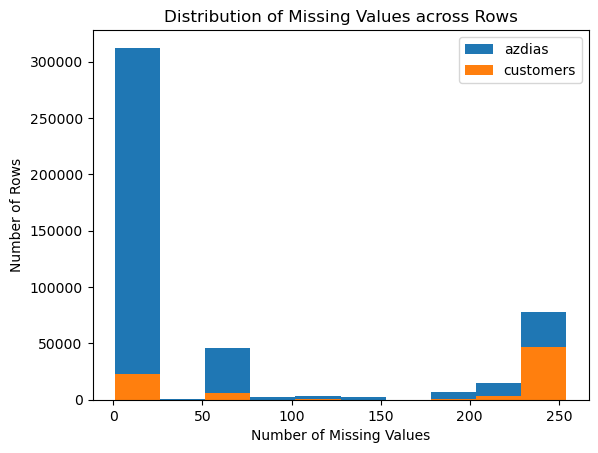

In [78]:
plt.hist(azdias_missing_rows.values, label='azdias')
plt.hist(customers_missing_rows.values, label='customers')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.legend()
plt.title('Distribution of Missing Values across Rows');

In [79]:
# get the % of row size
proportion_cols = {}
for percent in [20, 25, 50, 70, 75, 80]:
    proportion_cols[percent] = (percent/100)*azdias.shape[1]

proportion_cols

{20: 71.2, 25: 89.0, 50: 178.0, 70: 249.2, 75: 267.0, 80: 284.8}

In [80]:
# Get proportion of rows that would be dropped given a particular threshold (100) of missing values
get_missing_rows_percent(customers, 100), get_missing_rows_percent(azdias, 100)

(26.75735186692547, 11.87225166372875)

In [81]:
# Get proportion of rows that would be dropped given a particular threshold (25 % of columns length) of missing values
get_missing_rows_percent(customers, proportion_cols[25]), get_missing_rows_percent(azdias, proportion_cols[25])

(26.768309227140858, 11.890316767670422)

In [82]:
na_threshold_rows = np.ceil(proportion_cols[75])
na_threshold_rows

267.0

In [83]:
# value of thresh arg determines the minimum non-na values required beyond which the row is considered for dropping 
azdias.dropna(thresh=na_threshold_rows, axis=0, inplace=True)
customers.dropna(thresh=na_threshold_rows, axis=0, inplace=True)

Visualizing the missing data

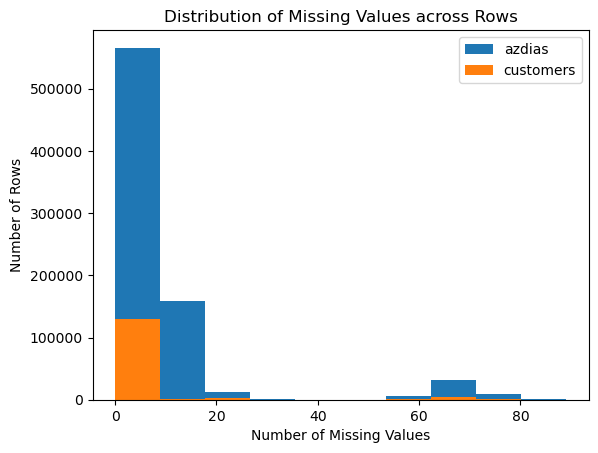

In [84]:
plt.hist(azdias.isnull().sum(axis=1).values, label='azdias')
plt.hist(customers.isnull().sum(axis=1).values, label='customers')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.legend()
plt.title('Distribution of Missing Values across Rows');

##### Checkpoint

In [85]:
with open('models/clean_data.pkl', 'wb') as file:
    dill.dump(clean_data, file)

In [86]:
azdias.to_pickle('data/azdias_cleaned.pkl')
customers.to_pickle('data/customers_cleaned.pkl')

In [88]:
azdias=pd.read_pickle('data/azdias_cleaned.pkl')
customers=pd.read_pickle('data/customers_cleaned.pkl')

### Feature Engineering by re-encoding certain columns

In [85]:
from src.pipelines import FeatureEngineer

In [86]:
feature_engine = FeatureEngineer(azdias)

#### Dealing with cameo Cols

In [87]:
get_attribute_info(cols_cameo[2], attributes)

,Attribute,Description,Value,Meaning,Missing
105,CAMEO_INTL_2015,CAMEO classification 2015 - international typo...,-1,unknown,True
106,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles,False
107,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,12,Wealthy Households-Young Couples With Children,False
108,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,13,Wealthy Households-Families With School Age Ch...,False
109,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,14,Wealthy Households-Older Families & Mature Co...,False
110,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,15,Wealthy Households-Elders In Retirement,False
111,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,21,Prosperous Households-Pre-Family Couples & Sin...,False
112,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,22,Prosperous Households-Young Couples With Children,False
113,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,23,Prosperous Households-Families With School Age...,False
114,CAMEO_INTL_2015,(each German CAMEO code belongs to one interna...,24,Prosperous Households-Older Families & Mature ...,False


In [88]:
# Create new columns by applying function to cameo cols
feature_engine.apply_transform('CAMEO_INTL_HH_ECON', cols_cameo[2], lambda x: x//10)
feature_engine.apply_transform('CAMEO_INTL_FAM_INFO', cols_cameo[2], lambda x: x%10)

In [89]:
# feature_engine.apply_transform('CAMEO_DEU_LEBENSSTIL', cols_cameo[1], lambda x: x[1] if type(x)==str else x)
# azdias['CAMEO_DEU_LEBENSSTIL'].unique()

In [90]:
# print(azdias['CAMEO_DEU_LEBENSSTIL'].unique())
# feature_engine.apply_remap('CAMEO_DEU_LEBENSSTIL', 'CAMEO_DEU_LEBENSSTIL', {'A':1, 'C':3, 'B':2, 'D':4, 'E':5, 'F':6})
# print(azdias['CAMEO_DEU_LEBENSSTIL'].unique())

#### Dealing with ther columns with extra encodings & other issues we noticed earlier 

In [91]:
LP_FAMILIE_GROB_attribute_values = get_attribute_info('LP_FAMILIE_GROB', attributes).copy()
LP_FAMILIE_GROB_attribute_values

,Attribute,Description,Value,Meaning,Missing
1903,LP_FAMILIE_GROB,familytyp rough,1,single,False
1904,LP_FAMILIE_GROB,familytyp rough,2,couple,False
1905,LP_FAMILIE_GROB,familytyp rough,3,single parent,False
1906,LP_FAMILIE_GROB,familytyp rough,4,NaN,NaN
1907,LP_FAMILIE_GROB,familytyp rough,5,NaN,NaN
1908,LP_FAMILIE_GROB,familytyp rough,6,family,False
1909,LP_FAMILIE_GROB,familytyp rough,7,NaN,NaN
1910,LP_FAMILIE_GROB,familytyp rough,8,NaN,NaN
1911,LP_FAMILIE_GROB,familytyp rough,9,multiperson household,False
1912,LP_FAMILIE_GROB,familytyp rough,10,NaN,NaN


In [92]:
azdias['LP_FAMILIE_GROB'].unique()

array([ 3.,  1., nan,  5.,  2.,  4.])

In [93]:
# Creates a dict using attributes df
LP_FAMILIE_GROB_attribute_values.Meaning = LP_FAMILIE_GROB_attribute_values.Meaning.str.strip()
# https://stackoverflow.com/questions/18695605/how-to-convert-a-dataframe-to-a-dictionary
LP_FAMILIE_GROB_attribute_values.ffill(inplace=True)
LP_FAMILIE_GROB_attribute_values['Meaning'].replace(
    {'single':1, 'couple':2, 'single parent':3, 'family':4, 'multiperson household':5},
    inplace=True)
LP_FAMILIE_GROB_dict = LP_FAMILIE_GROB_attribute_values.set_index('Value')['Meaning'].to_dict()

# Create new column from the applied encoding
feature_engine.apply_remap('LP_FAMILIE_GROB_HH', 'LP_FAMILIE_GROB', 
                           LP_FAMILIE_GROB_dict
                           )

In [94]:
LP_FAMILIE_FEIN_attribute_values = get_attribute_info('LP_FAMILIE_FEIN', attributes).copy()
LP_FAMILIE_FEIN_attribute_values

,Attribute,Description,Value,Meaning,Missing
1892,LP_FAMILIE_FEIN,familytyp fine,1,single,False
1893,LP_FAMILIE_FEIN,familytyp fine,2,couple,False
1894,LP_FAMILIE_FEIN,familytyp fine,3,young single parent,False
1895,LP_FAMILIE_FEIN,familytyp fine,4,single parent with teenager,False
1896,LP_FAMILIE_FEIN,familytyp fine,5,single parent with child of full age,False
1897,LP_FAMILIE_FEIN,familytyp fine,6,young family,False
1898,LP_FAMILIE_FEIN,familytyp fine,7,family with teenager,False
1899,LP_FAMILIE_FEIN,familytyp fine,8,family with child of full age,False
1900,LP_FAMILIE_FEIN,familytyp fine,9,shared flat,False
1901,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household,False


In [95]:
azdias['LP_FAMILIE_FEIN'].unique()

array([ 5.,  1., nan, 10.,  2.,  7., 11.,  8.,  4.,  6.,  9.,  3.])

In [96]:
# Create new column from the applied encoding
# We will use the dict above as the values are similar
feature_engine.apply_remap('LP_FAMILIE_FEIN_HH', 'LP_FAMILIE_FEIN',
                            LP_FAMILIE_GROB_dict
                            )

In [97]:
# Check unique values in above columns after transformations/replacement
for col in ['LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN']:
    get_unique_vals(azdias, col)

Unique Values in Column LP_FAMILIE_GROB:  [ 3.  1. nan  5.  2.  4.]
Unique Values in Column LP_FAMILIE_FEIN:  [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]


In [98]:
LP_FAMILIE_FEIN_attribute_values

,Attribute,Description,Value,Meaning,Missing
1892,LP_FAMILIE_FEIN,familytyp fine,1,single,False
1893,LP_FAMILIE_FEIN,familytyp fine,2,couple,False
1894,LP_FAMILIE_FEIN,familytyp fine,3,young single parent,False
1895,LP_FAMILIE_FEIN,familytyp fine,4,single parent with teenager,False
1896,LP_FAMILIE_FEIN,familytyp fine,5,single parent with child of full age,False
1897,LP_FAMILIE_FEIN,familytyp fine,6,young family,False
1898,LP_FAMILIE_FEIN,familytyp fine,7,family with teenager,False
1899,LP_FAMILIE_FEIN,familytyp fine,8,family with child of full age,False
1900,LP_FAMILIE_FEIN,familytyp fine,9,shared flat,False
1901,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household,False


In [99]:
# Creates a dict using attributes df
LP_FAMILIE_FEIN_attribute_values.Meaning = ['no_child', 'no_child', 'young', 
                                            'with_teenager', 'with_full_age_child', 
                                            'young', 'with_teenager', 'with_full_age_child',
                                            'shared', 'two_generational', 'multi_generational'
                                            ]
LP_FAMILIE_FEIN_attribute_values.Meaning.replace({'no_child':1, 'young':2, 'with_teenager':3, 'with_full_age_child':4, 
                                                  'shared':5, 'two_generational':6, 'multi_generational':7},
                                                   inplace=True
                                                   )

LP_FAMILIE_FEIN_dict = LP_FAMILIE_FEIN_attribute_values.set_index("Value")['Meaning'].to_dict()

# Create new column from the applied encoding
feature_engine.apply_remap('LP_FAMILIE_FEIN_INFO', 'LP_FAMILIE_FEIN', LP_FAMILIE_FEIN_dict)

In [100]:
azdias['LP_FAMILIE_FEIN_INFO'].unique()

array([ 4.,  1., nan,  6.,  3.,  7.,  2.,  5.])

In [101]:
LP_STATUS_GROB_attribute_values = get_attribute_info('LP_STATUS_GROB', attributes).copy()
LP_STATUS_GROB_attribute_values

,Attribute,Description,Value,Meaning,Missing
1976,LP_STATUS_GROB,social status rough,1,low-income earners,False
1977,LP_STATUS_GROB,social status rough,2,NaN,NaN
1978,LP_STATUS_GROB,social status rough,3,average earners,False
1979,LP_STATUS_GROB,social status rough,4,NaN,NaN
1980,LP_STATUS_GROB,social status rough,5,NaN,NaN
1981,LP_STATUS_GROB,social status rough,6,independants,False
1982,LP_STATUS_GROB,social status rough,7,NaN,NaN
1983,LP_STATUS_GROB,social status rough,8,houseowners,False
1984,LP_STATUS_GROB,social status rough,9,NaN,NaN
1985,LP_STATUS_GROB,social status rough,10,top earners,False


In [102]:
azdias['LP_STATUS_GROB'].unique()

array([ 1.,  2.,  4.,  5.,  3., nan])

In [103]:
# Creates a dict using attributes df
LP_STATUS_GROB_attribute_values.Meaning.ffill(inplace=True)
LP_STATUS_GROB_attribute_values.Meaning.replace({'low-income earners':1, 'average earners':2, 
                                                 'independants':3, 'houseowners':4, 'top earners ':5
                                                 },
                                                 inplace=True
                                                )
LP_STATUS_GROB_dict = LP_STATUS_GROB_attribute_values.set_index('Value')['Meaning'].to_dict()

# Replace column values using the applied encoding
feature_engine.apply_remap('LP_STATUS_GROB', 'LP_STATUS_GROB', LP_STATUS_GROB_dict)

In [104]:
azdias['LP_STATUS_GROB'].unique()

array([ 1.,  2., nan])

In [105]:
LP_LEBENSPHASE_FEIN_attribute_values = get_attribute_info('LP_LEBENSPHASE_FEIN', attributes).copy()
LP_LEBENSPHASE_FEIN_attribute_values

,Attribute,Description,Value,Meaning,Missing
1914,LP_LEBENSPHASE_FEIN,lifestage fine,1,single low-income earners of younger age,False
1915,LP_LEBENSPHASE_FEIN,lifestage fine,2,single low-income earners of middle age,False
1916,LP_LEBENSPHASE_FEIN,lifestage fine,3,single average earners of younger age,False
1917,LP_LEBENSPHASE_FEIN,lifestage fine,4,single average earners of middle age,False
1918,LP_LEBENSPHASE_FEIN,lifestage fine,5,single low-income earners of advanced age,False
1919,LP_LEBENSPHASE_FEIN,lifestage fine,6,single low-income earners at retirement age,False
1920,LP_LEBENSPHASE_FEIN,lifestage fine,7,single average earners of advanced age,False
1921,LP_LEBENSPHASE_FEIN,lifestage fine,8,single average earners at retirement age,False
1922,LP_LEBENSPHASE_FEIN,lifestage fine,9,single independant persons,False
1923,LP_LEBENSPHASE_FEIN,lifestage fine,10,wealthy single homeowners,False


In [106]:
# Create a dict of encodings using attributes df
LP_LEBENSPHASE_FEIN_attribute_values.Meaning = ['younger', 'middle', 'younger', 'middle', 'advanced', 
                                                'retirement', 'advanced', 'retirement', 'middle', 'middle',
                                                'advanced', 'retirement', 'higher', 'younger', 'higher', 
                                                'higher', 'middle', 'younger', 'higher', 'higher',
                                                'middle', 'middle', 'middle', 'middle', 'middle', 
                                                'middle', 'middle', 'middle', 'younger', 'younger',
                                                'higher', 'higher', 'younger', 'younger', 'younger', 
                                                'higher', 'advanced', 'retirement', 'middle', 'retirement']
LP_LEBENSPHASE_FEIN_attribute_values.Meaning.replace({'younger':1, 'middle':2, 'higher':3, 'advanced':4, 'retirement':5}, 
                                                     inplace=True
                                                     )
LP_LEBENSPHASE_FEIN_dict = LP_LEBENSPHASE_FEIN_attribute_values.set_index('Value')['Meaning'].to_dict()

# Create a new column using above dict
feature_engine.apply_remap('LP_LEBENSPHASE_FEIN_ALTER', 'LP_LEBENSPHASE_FEIN', LP_LEBENSPHASE_FEIN_dict)

In [107]:
azdias['LP_LEBENSPHASE_FEIN_ALTER'].unique()

array([ 2.,  1., nan,  3.,  5.,  4.])

In [108]:
# Create a dict of encodings using attributes df
lebensphase_einkomnen = ['low', 'low', 'average', 'average', 'low', 
                         'low', 'average', 'average', 'average', 'wealthy',
                         'average', 'average', 'top', 'average', 'low', 
                         'average', 'average', 'wealthy', 'wealthy', 'top', 
                         'low', 'average', 'wealthy', 'low', 'average', 
                         'average', 'average', 'top', 'low', 'average', 
                         'low', 'average', 'average', 'average', 'top',
                         'average', 'average', 'average', 'top', 'top']
LP_LEBENSPHASE_FEIN_attribute_values.Meaning = lebensphase_einkomnen
LP_LEBENSPHASE_FEIN_attribute_values.Meaning.replace({'low':1, 'average':2, 'wealthy':3, 'top':4}, inplace=True)
LP_LEBENSPHASE_FEIN_einkomnen_dict = LP_LEBENSPHASE_FEIN_attribute_values.set_index('Value')['Meaning'].to_dict()

# Create a new column using above encoding dict
feature_engine.apply_remap('LP_LEBENSPHASE_FEIN_EINK', 'LP_LEBENSPHASE_FEIN', LP_LEBENSPHASE_FEIN_einkomnen_dict)

In [109]:
azdias['LP_LEBENSPHASE_FEIN_EINK'].unique()

array([ 1.,  2., nan,  3.,  4.])

In [110]:
azdias['LP_STATUS_FEIN'].unique()

array([ 2.,  3.,  9.,  4.,  1., 10.,  5.,  8.,  6.,  7., nan])

In [111]:
get_attribute_info('WOHNLAGE', attributes)

,Attribute,Description,Value,Meaning,Missing
2229,WOHNLAGE,residential-area,-1,unknown,True
2230,WOHNLAGE,residential-area,0,no score calculated,False
2231,WOHNLAGE,residential-area,1,very good neighbourhood,False
2232,WOHNLAGE,residential-area,2,good neighbourhood,False
2233,WOHNLAGE,residential-area,3,average neighbourhood,False
2234,WOHNLAGE,residential-area,4,poor neighbourhood,False
2235,WOHNLAGE,residential-area,5,very poor neighbourhood,False
2236,WOHNLAGE,residential-area,7,rural neighbourhood,False
2237,WOHNLAGE,residential-area,8,new building in rural neighbourhood,False


In [112]:
azdias['WOHNLAGE'].unique()

array([ 4.,  2.,  7.,  3.,  5.,  1.,  8., nan])

In [113]:
# Create new column indicating rural neighbourhood
feature_engine.apply_transform('WOHNLAGE_LANDLICH', 'WOHNLAGE', lambda x: 1 if ((x==7) or (x==8)) else 0)

In [114]:
azdias['WOHNLAGE_LANDLICH'].unique()

array([0, 1], dtype=int64)

In [115]:
# Create new columns based on class of neighbourhood w.r.t. ordinal scale
feature_engine.apply_remap('WOHNLAGE_KLASSE', 'WOHNLAGE', {5:1, 4:2, 3:3, 2:4, 1:5, 7:1, 8:2})
# Create new columns based on type of neighbourhood w.r.t. ordinal scale 
feature_engine.apply_remap('WOHNLAGE_TYP', 'WOHNLAGE', {5:3, 4:4, 3:5, 2:6, 1:7, 7:1, 8:2})

In [116]:
azdias.dtypes[azdias.dtypes == object]

CAMEO_DEU_2015              object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
dtype: object

In [117]:
# Create numerical encodings for D19_LETZTER_KAUF_BRANCHE column
# sklearn's column transformers and categorical encoder would have also worked
LETZTER_KAUF_BRANCHE_dict = {v:k for k, v in enumerate([category for category in list(azdias['D19_LETZTER_KAUF_BRANCHE'].unique()) if type(category)==str])}

# Apply encodings
feature_engine.apply_remap('D19_LETZTER_KAUF_BRANCHE', 'D19_LETZTER_KAUF_BRANCHE', LETZTER_KAUF_BRANCHE_dict)

In [118]:
azdias['D19_LETZTER_KAUF_BRANCHE'].unique()

array([nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28., 29., 30., 31., 32., 33., 34.])

In [119]:
# Create numerical encodings using values in attributes df 
cameo_deu_2015_map = {v:k+1 for k,v in enumerate(attributes[attributes.Attribute=='CAMEO_DEU_2015'].Value)}

# Apply encodings
feature_engine.apply_remap('CAMEO_DEU_2015', cols_cameo[1], cameo_deu_2015_map)

In [120]:
CAMEO_DEUG_attribute_values = get_attribute_info(cols_cameo[0], attributes).copy()
CAMEO_DEUG_attribute_values

,Attribute,Description,Value,Meaning,Missing
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown,True
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class,False
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass,False
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse,False
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass,False
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass,False
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass,False
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass,False
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class,False
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class,False


In [121]:
azdias[cols_cameo[0]].unique()

array([ 8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3., nan])

In [122]:
# Create new columns based on income class w.r.t. ordinal scale
feature_engine.apply_remap(f'{cols_cameo[0]}_KLASSE', cols_cameo[0], {8:1,9:1,7:2,6:2,5:2,4:2,3:2,2:2,1:3})
feature_engine.apply_remap(f'{cols_cameo[0]}_TYP', cols_cameo[0], {8:1,9:2,7:3,6:4,5:5,4:6,3:7,2:8,1:9})

In [123]:
# Apply all transformations to customers dataframe
feature_engine.transform(customers)

In [124]:
# Checking if columns are same
assert(len(set(azdias.columns)-set(customers.columns)) == 0)
assert(len(set(customers.columns)-set(azdias.columns)) == 0)

In [125]:
# Clearing up memory usage
for i in [LP_FAMILIE_GROB_attribute_values, LP_FAMILIE_FEIN_attribute_values, LP_STATUS_GROB_attribute_values, LP_LEBENSPHASE_FEIN_attribute_values]:
    i = None

In [126]:
# Dropping columns that have become redundant after above processing
# LNR represents unique code for each observation & 'EINGEFUEGT_AM' literally translates to inserted on
azdias.drop(['LNR', 'EINGEFUEGT_AM', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'CAMEO_INTL_2015'], axis=1, inplace=True)
customers.drop(['LNR', 'EINGEFUEGT_AM', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'CAMEO_INTL_2015'], axis=1, inplace=True)

In [127]:
def reduce_mem_usage(df):
    '''Reduce Memory usage of df'''
    int_64_cols = df.select_dtypes(include='int64').columns
    df[int_64_cols] = df[int_64_cols].astype('int32')

    float_64_cols = df.select_dtypes(include='float64').columns
    df[float_64_cols] = df[float_64_cols].astype('float32')

In [128]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785252 entries, 1 to 891220
Columns: 363 entries, AKT_DAT_KL to CAMEO_DEUG_2015_TYP
dtypes: float64(276), int64(87)
memory usage: 2.1 GB


In [129]:
reduce_mem_usage(azdias)

In [130]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785252 entries, 1 to 891220
Columns: 363 entries, AKT_DAT_KL to CAMEO_DEUG_2015_TYP
dtypes: float32(276), int32(87)
memory usage: 1.1 GB


In [131]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140350 entries, 0 to 191651
Columns: 363 entries, AKT_DAT_KL to CAMEO_DEUG_2015_TYP
dtypes: float64(276), int64(87)
memory usage: 389.8 MB


In [132]:
reduce_mem_usage(customers)

In [133]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140350 entries, 0 to 191651
Columns: 363 entries, AKT_DAT_KL to CAMEO_DEUG_2015_TYP
dtypes: float32(276), int32(87)
memory usage: 195.4 MB


##### Checkpoint

In [137]:
with open('models/feat_eng.pkl', 'wb') as handle:
    dill.dump(feature_engine, handle)

In [138]:
azdias.to_pickle('data/azdias_feat_engineered.pkl')
customers.to_pickle('data/customers_feat_engineered.pkl')

In [179]:
azdias = pd.read_pickle('data/azdias_feat_engineered.pkl')
customers = pd.read_pickle('data/customers_feat_engineered.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Impute missing Values

In [134]:
# impute = Imputer(strategy='most_frequent')
imputer = SimpleImputer(strategy='median')
imputer.set_output(transform='pandas')

imputer.fit(azdias)
azdias = imputer.transform(azdias)
customers = imputer.transform(customers)

##### Checkpoint

In [140]:
azdias.to_pickle('data/azdias_imputed.pkl')
customers.to_pickle('data/customers_imputed.pkl')

In [ ]:
azdias = pd.read_pickle('data/azdias_imputed.pkl')
customers = pd.read_pickle('data/customers_imputed.pkl')

#### Scale Values before performing dimensional reduction

In [135]:
scaler = StandardScaler()

scaler.fit(azdias)
scaler.set_output(transform='pandas')

azdias = pd.DataFrame(scaler.transform(azdias), columns=azdias.columns)

customers = pd.DataFrame(scaler.transform(customers), columns=customers.columns)

##### Checkpoint

In [142]:
azdias.to_pickle('data/azdias_scaled.pkl')
customers.to_pickle('data/customers_scaled.pkl')

In [5]:
azdias = pd.read_pickle('data/azdias_scaled.pkl')
customers = pd.read_pickle('data/customers_scaled.pkl')

### Perform PCA

In [136]:
pca = PCA(random_state=randomState)
pca.fit(azdias)

PCA(random_state=42)

In [137]:
variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance)

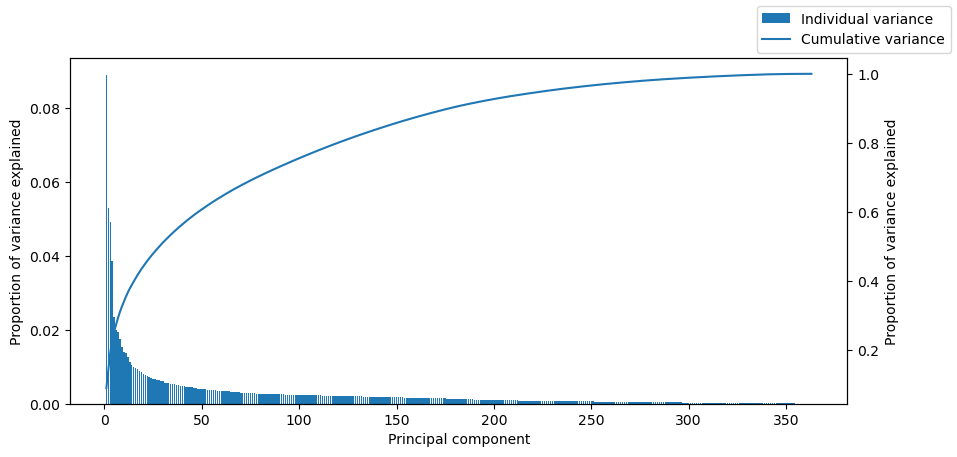

In [138]:
# Plot Variance explained by Components
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(range(1, len(variance)+1), variance, label='Individual variance')
ax1.set_xlabel('Principal component')
ax1.set_ylabel('Proportion of variance explained')
ax2 = ax1.twinx()
ax2.plot(range(1, len(variance)+1), cumulative_variance, label='Cumulative variance')
ax2.set_ylabel('Proportion of variance explained')
fig.legend()
fig.tight_layout(pad=4)
plt.show();

In [139]:
# Check thresholds
indices_evr_lt_90 = np.where(cumulative_variance<=0.90)
indices_evr_gt_90 = np.where(cumulative_variance>0.90)
indices_evr_lt_90[0][-1], indices_evr_gt_90[0][0]

(176, 177)

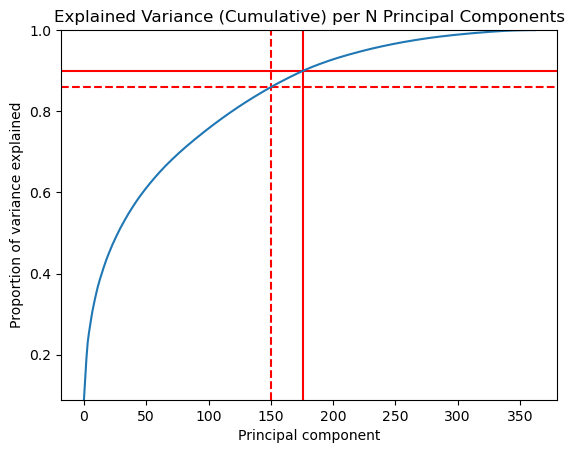

In [140]:
# Plot lines indicating thresholds
plt.ylim(min(cumulative_variance))
plt.axhline(y=0.9, color='r')
plt.axvline(x=176, color='r')

plt.axhline(y=0.86, color='r', linestyle='--')
plt.axvline(x=150, color='r', linestyle='--')

plt.plot(cumulative_variance)
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.title("Explained Variance (Cumulative) per N Principal Components")
plt.show();

#### We will perform PCA considering both ~90% & ~85% of variance explained

In [141]:
# PCA with 176 Components ~ 90% Variance
pca_176 = PCA(random_state=randomState, n_components=176)
pca_176.fit(azdias)
azdias_pca_176 = pca_176.transform(azdias)
customers_pca_176 = pca_176.transform(customers)

#### Plotting Explained Variance of Components

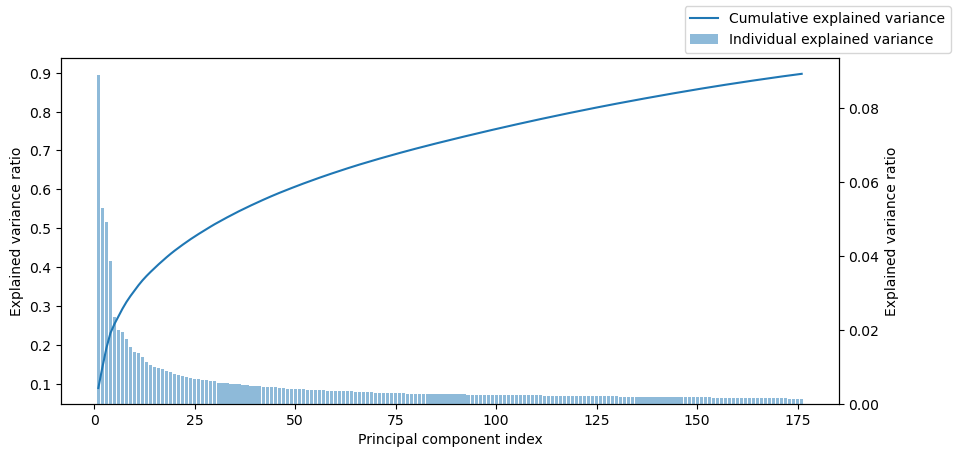

In [142]:
plot_evr(pca_176)

#### Check Feature Weights of top 4 components

In [143]:
top_feature_weights_list = [get_feature_weights(pca_176, azdias, i) for i in range(4)]

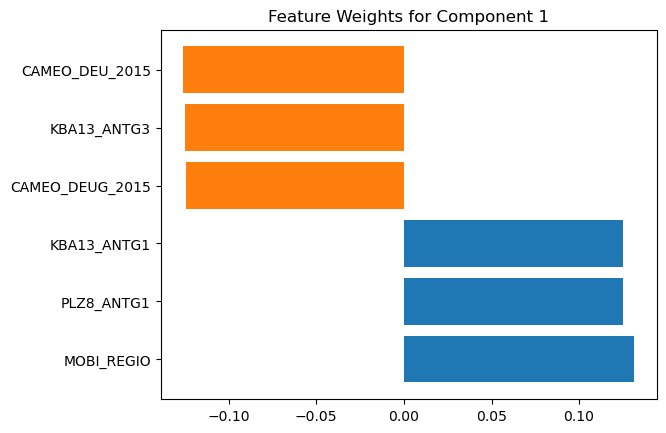

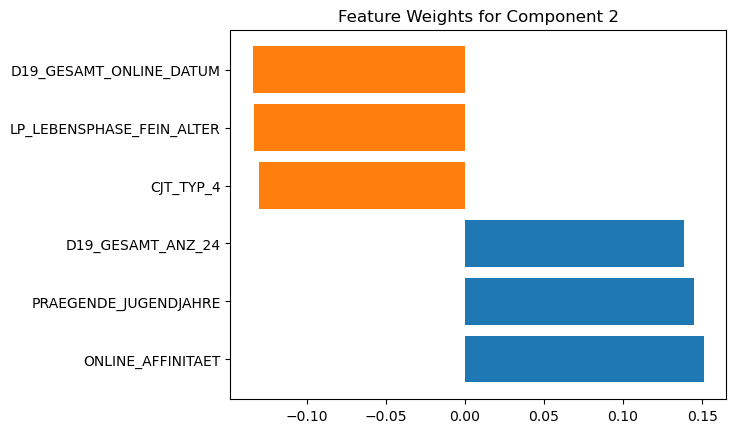

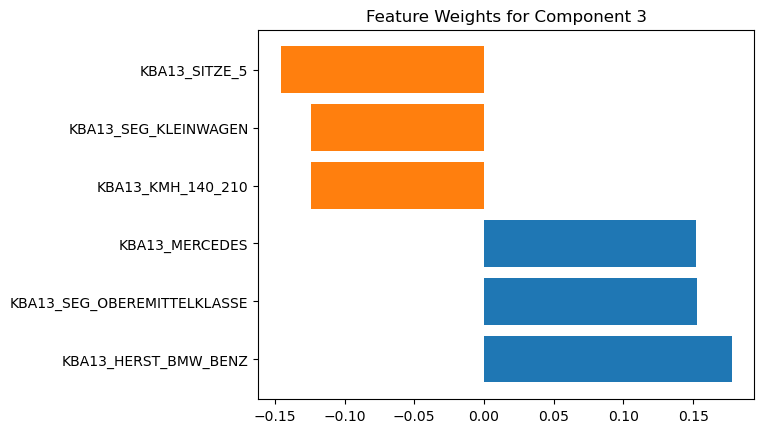

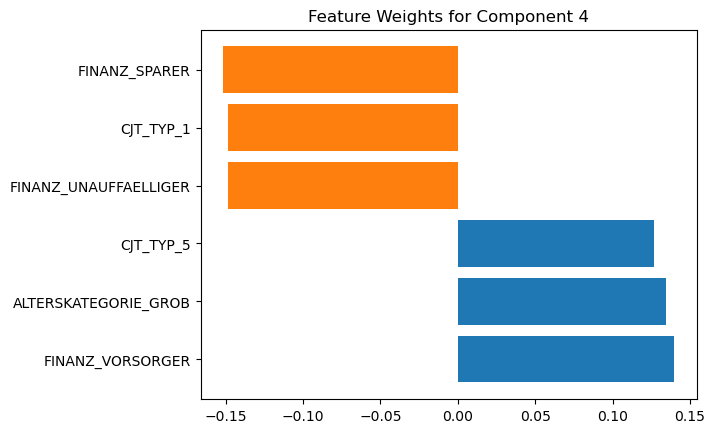

In [146]:
for i in range(4):
    feature_weights_i = top_feature_weights_list[i]
    plt.title(f'Feature Weights for Component {i+1}')
    plot_feature_weights(feature_weights_i)

### KMeans Clusering

#### Elbow method to choose optimum number of clusters

We will use yellowbrick's KElbowVisualizer to visualize the optimum value

In [147]:
from src.modelling import plot_elbow

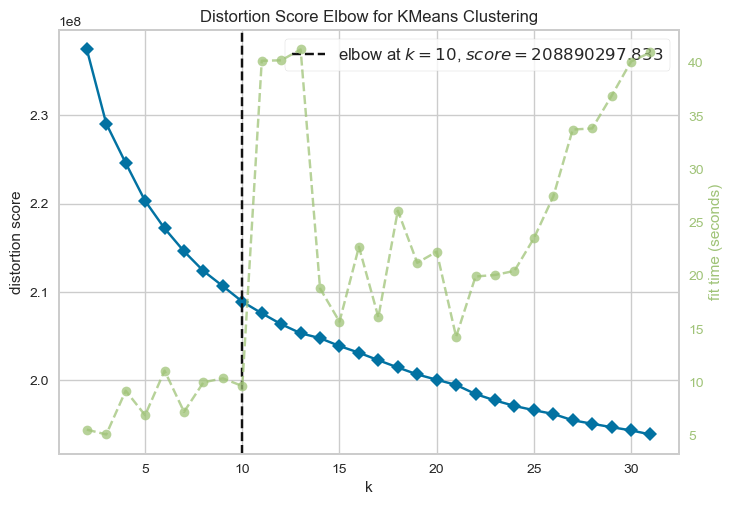

In [148]:
plot_elbow(azdias_pca_176)

In [149]:
# KMeans Clustering for data with 176 dims
kmeans = KMeans(n_clusters=10, random_state=randomState, n_init='auto')
kmeans.fit(azdias_pca_176)
azdias_clusters = kmeans.predict(azdias_pca_176)
customers_clusters = kmeans.predict(customers_pca_176)

In [150]:
from src.utils import plot_clusters

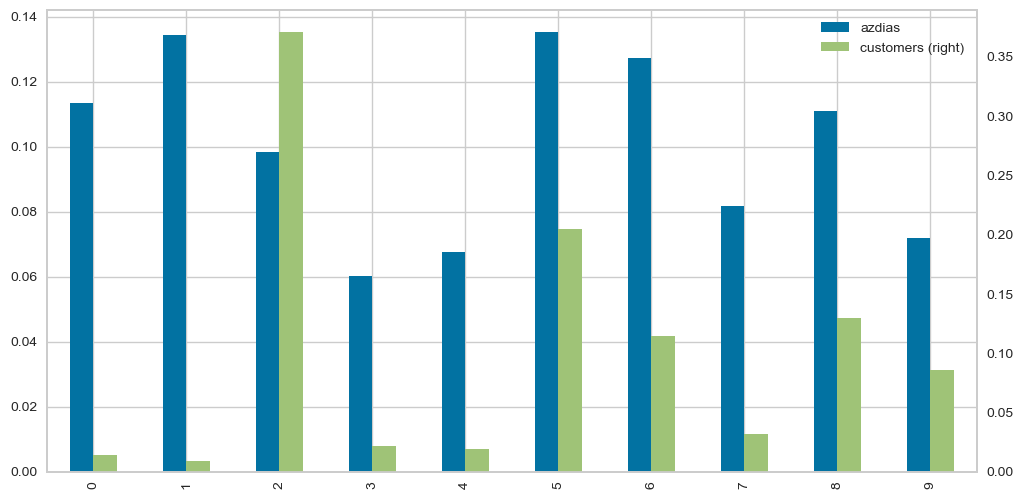

In [151]:
# Plot Num of Observations in each Cluster for data with 176 dims
plot_clusters(azdias_clusters, customers_clusters)

In [162]:
# with open('models/imputer.pkl', 'wb') as imputer_pkl:
#     pickle.dump(imputer, imputer_pkl)

# with open('models/scaler.pkl', 'wb') as scaler_pkl:
#     pickle.dump(scaler, scaler_pkl)

# with open('models/pca_176.pkl', 'wb') as pca_pkl:
#     pickle.dump(pca_176, pca_pkl)

# with open('models/kmeans.pkl', 'wb') as kmeans_pkl:
#     pickle.dump(kmeans, kmeans_pkl)

# with open('metadata/high_cardinality_klasse_type_cols.pkl', 'wb') as cols_pkl:
#     pickle.dump(high_cardinality_klasse_type_cols, cols_pkl)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# with open('models/imputer.pkl', 'rb') as imputer_pkl:
#     pickle.load(imputer, imputer_pkl)

# with open('models/scaler.pkl', 'rb') as scaler_pkl:
#     pickle.dump(scaler, scaler_pkl)

# with open('models/pca_176.pkl', 'rb') as pca_pkl:
#     pickle.dump(pca_176, pca_pkl)

# with open('models/kmeans.pkl', 'rb') as kmeans_pkl:
#     pickle.dump(kmeans, kmeans_pkl)

# with open('metadata/high_cardinality_klasse_type_cols.pkl', 'rb') as cols_pkl:
#     pickle.dump(high_cardinality_klasse_type_cols, cols_pkl)

In [163]:
# with open('models/clean_data.pkl', 'rb') as clean:
#     clean_data = dill.load(clean)

In [164]:
# with open('models/feat_eng.pkl', 'rb') as fe:
#     feature_engine = dill.load(fe)

### Train

In [152]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Satya\AppData\Local\Temp\ipykernel_23664\2290286062.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


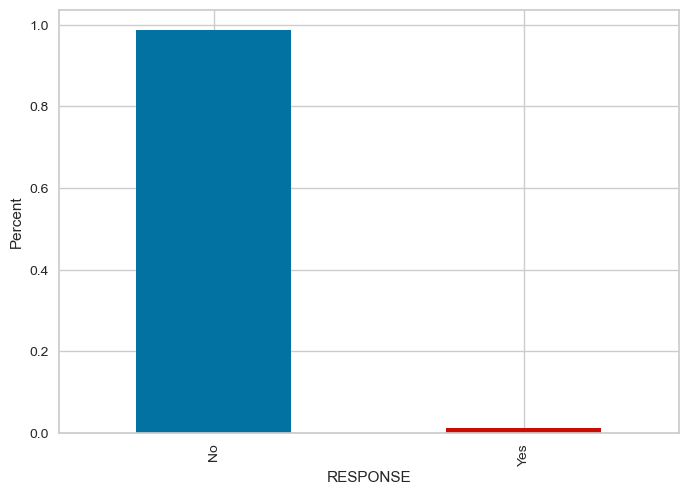

In [155]:
response_counts = mailout_train['RESPONSE'].value_counts()/len(mailout_train['RESPONSE'])
response_counts.plot.bar(color=['b', 'r'])
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.xlabel('RESPONSE')
plt.ylabel('Percent')
plt.show();

In [156]:
# Applying All Transformations\Processing applied to Gen Pop & Customers Data
clean_data.transform(mailout_train)
mailout_train_clean = mailout_train.copy()
feature_engine.transform(mailout_train_clean)

In [157]:
# Dropping Columns
mailout_train_clean.drop(list(get_cols_to_drop(mailout_train_clean, 0.30)), axis=1, inplace=True)
mailout_train_clean.drop(['EINGEFUEGT_AM', 'LNR', 
                          'CAMEO_INTL_2015', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN'
                          ], axis=1, inplace=True)

In [158]:
# Creating X, y for modelling
X_train, y_train = mailout_train_clean.drop('RESPONSE', axis=1), mailout_train_clean['RESPONSE']

# Verifying Integrity
assert(X_train.shape[1] == azdias.shape[1])

#### Some more Feature Engineering

In [159]:
# Adding New Features to capture information learn during the Unsupervided learning part i.e. Customer Segmentation
# We use the dimensional reduction and KMeans clustering performed on azdias dataset to get two new features
X_train_imputed = imputer.transform(X_train)
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_pca_176 = pca_176.transform(X_train_imputed_scaled)
cluster_p176_c10 = kmeans.predict(X_train_pca_176)
X_train_imputed['cluster_p176_c10'] = cluster_p176_c10

In [160]:
# Creating One Hot Encoding for Certain Columns
ohe_cols = list((set(klasse_type_cols)-set(high_cardinality_klasse_type_cols))&set(mailout_train_clean.columns))
X_train_ohe = pd.get_dummies(X_train_imputed, columns=ohe_cols)

In [161]:
# Imports for modelling
from sklearn.metrics import roc_auc_score
from src.modelling import GridSearch_ClassifierCV

##### Creating train dataset & labels that will taken as inputs by classification algorithms

In [162]:
# train = X_train_ohe
train = pd.concat([X_train_ohe, X_train_imputed[ohe_cols]], axis=1)

labels = y_train

Reduce mem usage

In [163]:
azdias = None
customers = None

In [164]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [165]:
# for hyper parameter for imbalanced dataset
scale_pos_weight = sum(y_train==0)/sum(y_train==1)
scale_pos_weight

79.75563909774436

In [166]:
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        random_state=randomState
                        )
xgb_param_grid = {
                  'scale_pos_weight': [None, 10, scale_pos_weight],
                  'learning_rate':[0.1,0.01],
                  'max_depth': [3,12,24]
                 }
                 
xgb_grid = GridSearch_ClassifierCV(xgb_clf, train, labels,
                                   params=xgb_param_grid,
                                   cv=3
                                  )
xgb_grid.best_score_, xgb_grid.best_params_

(0.764680952419457,
 {'learning_rate': 0.1, 'max_depth': 3, 'scale_pos_weight': None})

In [167]:
lgb_clf = LGBMClassifier(objective='binary',
                        random_state=randomState,
                        )

lgb_param_grid = {# 'feature_fraction':[1, 0.9],
                  'boosting_type' : ['gbdt', 'dart'],
                  'max_depth': [50, 100],
                  'is_unbalance' : [True, None]
                 # 'num_leaves':[100, 500]
                 }
                 
lgb_grid = GridSearch_ClassifierCV(lgb_clf, train, labels,
                                   params=lgb_param_grid,
                                   cv=3
                                  )
lgb_grid.best_score_, lgb_grid.best_params_

(0.7586573733567302,
 {'boosting_type': 'dart', 'is_unbalance': None, 'max_depth': 50})

In [168]:
rf_clf = RandomForestClassifier(random_state=randomState
                                )
rf_param_grid = {
                 'max_depth': [10, 50, 90],
                 'n_estimators':[100, 500, 900]
                 }
                 
rf_grid = GridSearch_ClassifierCV(rf_clf, train, labels,
                                  params=rf_param_grid,
                                  cv=3
                                  )
rf_grid.best_score_, rf_grid.best_params_

(0.6668600760932467, {'max_depth': 10, 'n_estimators': 900})

#### Algorithms/Techniques to deal with Imbalanced data

In [169]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [170]:
xgb_imb_clf = XGBClassifier(objective='binary:logistic', 
                            random_state=randomState
                            )

xgb_imb_param_grid = {
                      'learning_rate':[0.1,0.01],
                      'max_depth': [3,12,24]
                      }

xgb_imb_clf_pipeline = Pipeline([('smote', SMOTE(random_state=randomState)),
                                 ('classifier', xgb_imb_clf) 
                                 ])

xgb_imb_grid = GridSearch_ClassifierCV(xgb_imb_clf_pipeline, train, labels,
                                       params={'classifier__'+k:v for k,v in xgb_imb_param_grid.items()},
                                       cv=3
                                       )

xgb_imb_grid.best_score_, xgb_imb_grid.best_params_

(0.7444815808662346,
 {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3})

In [171]:
lgb_imb_clf = LGBMClassifier(objective='binary',
                        random_state=randomState,
                        )

lgb_imb_param_grid = {
                      'boosting_type' : ['gbdt', 'dart'],
                      'max_depth': [50, 100],
                      }

lgb_imb_clf_pipeline = Pipeline([('smote', SMOTE(random_state=randomState)),
                                 ('classifier', lgb_imb_clf) 
                                 ])

lgb_imb_grid = GridSearch_ClassifierCV(lgb_imb_clf_pipeline, train, labels,
                                       params={'classifier__'+k:v for k,v in lgb_imb_param_grid.items()},
                                       cv=3
                                      )

lgb_imb_grid.best_score_, lgb_imb_grid.best_params_

(0.689834570512831,
 {'classifier__boosting_type': 'gbdt', 'classifier__max_depth': 50})

In [172]:
rf_imb_clf = RandomForestClassifier(random_state=randomState
                                    )
rf_imb_param_grid = {
                     'max_depth': [50, 90],
                     'n_estimators':[500, 900]
                     }
                 
rf_imb_clf_pipeline = Pipeline([('smote', SMOTE(random_state=randomState)),
                                ('classifier', rf_imb_clf) 
                                ])

rf_imb_grid = GridSearch_ClassifierCV(rf_imb_clf_pipeline, train, labels,
                                      params={'classifier__'+k:v for k,v in rf_imb_param_grid.items()},
                                      cv=3
                                      )

rf_imb_grid.best_score_, rf_imb_grid.best_params_

(0.6371978247509427,
 {'classifier__max_depth': 90, 'classifier__n_estimators': 900})

#### Summarise Grid Search Results

In [173]:
summary_df = pd.DataFrame({'model': ['xgboost', 'lightgbm', 'randomforest', 
                                     'xgboost with smote', 'lightgbm with smote', 
                                     'randomforest with smote'
                                     ],
                            'best_params': [xgb_grid.best_params_, lgb_grid.best_params_, rf_grid.best_params_, 
                                            xgb_imb_grid.best_params_, lgb_imb_grid.best_params_, 
                                            rf_imb_grid.best_params_
                                            ],
                            'score': [xgb_grid.best_score_, lgb_grid.best_score_, rf_grid.best_score_, 
                                      xgb_imb_grid.best_score_, lgb_imb_grid.best_score_, 
                                      rf_imb_grid.best_score_
                                      ]
                           })

with pd.option_context('display.max_colwidth', None):
    display(summary_df)

,model,best_params,score
0,xgboost,"{'learning_rate': 0.1, 'max_depth': 3, 'scale_pos_weight': None}",0.764681
1,lightgbm,"{'boosting_type': 'dart', 'is_unbalance': None, 'max_depth': 50}",0.758657
2,randomforest,"{'max_depth': 10, 'n_estimators': 900}",0.666860
3,xgboost with smote,"{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3}",0.744482
4,lightgbm with smote,"{'classifier__boosting_type': 'gbdt', 'classifier__max_depth': 50}",0.689835
5,randomforest with smote,"{'classifier__max_depth': 90, 'classifier__n_estimators': 900}",0.637198


#### Retraining models using best params obtained above on entire dataset

In [174]:
model = XGBClassifier(objective='binary:logistic', random_state=randomState,
                      **xgb_grid.best_params_
                      )
model.fit(train, labels)

y_pred_probab = model.predict_proba(train)[:, 1]
roc_auc_score(y_train, y_pred_probab)

0.878149592694912

In [175]:
light_model = LGBMClassifier(random_state=randomState,
                             objective='binary',
                             **lgb_grid.best_params_
                             )
light_model.fit(train, labels)

y_pred_light_probab = light_model.predict_proba(train)[:, 1]
roc_auc_score(y_train, y_pred_light_probab)

0.9301486393334267

In [176]:
forest_model = RandomForestClassifier(random_state=randomState,
                                      **rf_grid.best_params_
                                      )
forest_model.fit(train, labels)

y_pred_forest_probab = forest_model.predict_proba(train)[:, 1]
roc_auc_score(y_train, y_pred_forest_probab)

0.955797009315653

In [177]:
# Synthetic Minority Oversampling Technique
sm = SMOTE(random_state=randomState)
train_resampled, labels_resampled = sm.fit_resample(train, labels)

In [178]:
model_imb = XGBClassifier(objective='binary:logistic', 
                          random_state=randomState,
                         **{k.split('__')[1]:v for k,v in xgb_imb_grid.best_params_.items()}
                      )
model_imb.fit(train_resampled, labels_resampled)

y_pred_imb_probab = model_imb.predict_proba(train)[:, 1]
roc_auc_score(y_train, y_pred_imb_probab)

0.7695094662770525

In [179]:
light_imb_model = LGBMClassifier(random_state=randomState,
                                 objective='binary',
                                 **{k.split('__')[1]: v for k, v in lgb_imb_grid.best_params_.items()}
                                 )
light_imb_model.fit(train_resampled, labels_resampled)

y_pred_imb_light_probab = light_imb_model.predict_proba(train)[:, 1]
roc_auc_score(y_train, y_pred_imb_light_probab)

0.8973981249966774

In [180]:
forest_imb_model = RandomForestClassifier(random_state=randomState,
                                          **{k.split('__')[1]: v for k, v in rf_imb_grid.best_params_.items()}
                                          )
forest_imb_model.fit(train_resampled, labels_resampled)

y_pred_imb_forest_probab = forest_imb_model.predict_proba(train)[:, 1]
roc_auc_score(y_train, y_pred_imb_forest_probab)

0.9919829697387472

#### Summarise Evaluation Scores on training data

In [181]:
results_df = pd.DataFrame({'model': ['xgboost', 'lightgbm', 'randomforest', 
                                     'xgboost with smote', 'lightgbm with smote', 
                                     'randomforest with smote'
                                     ],
                            'training score': [roc_auc_score(y_train, y_pred_probab), 
                                               roc_auc_score(y_train, y_pred_light_probab),
                                               roc_auc_score(y_train, y_pred_forest_probab),
                                               roc_auc_score(y_train, y_pred_imb_probab),
                                               roc_auc_score(y_train, y_pred_imb_light_probab),
                                               roc_auc_score(y_train, y_pred_imb_forest_probab)                                               
                                               ]
                           })
results_df

,model,training score
0,xgboost,0.878150
1,lightgbm,0.930149
2,randomforest,0.955797
3,xgboost with smote,0.769509
4,lightgbm with smote,0.897398
5,randomforest with smote,0.991983


In [182]:
# save models
with open('models/xgb.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
with open('models/lgb.pkl', 'wb') as model_file:
    pickle.dump(light_model, model_file)
with open('models/rf.pkl', 'wb') as model_file:
    pickle.dump(forest_model, model_file)
with open('models/xgb_smote.pkl', 'wb') as model_file:
    pickle.dump(model_imb, model_file)
with open('models/lgb_smote.pkl', 'wb') as model_file:
    pickle.dump(light_imb_model, model_file)
with open('models/rf_smote.pkl', 'wb') as model_file:
    pickle.dump(forest_imb_model, model_file)

### TEST

In [183]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Satya\AppData\Local\Temp\ipykernel_23664\440238055.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [184]:
# Applying All Transformations\Processing applied to Gen Pop & Customers Data
clean_data.transform(mailout_test)
mailout_test_clean = mailout_test.copy()
feature_engine.transform(mailout_test_clean)

In [185]:
# Dropping Columns
mailout_test_clean.drop(get_cols_to_drop(mailout_test_clean, 0.3), axis=1, inplace=True)
mailout_test_clean.drop(['EINGEFUEGT_AM', 
                         'CAMEO_INTL_2015', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN'
                         ], 
                         axis=1, inplace=True
                         )

In [186]:
# Dropping ID column
X_test = mailout_test_clean.drop('LNR', axis=1)

In [187]:
# Adding Features created from information extracted by KMeans model 
X_test_imputed = imputer.transform(X_test)
X_test_imputed_scaled = scaler.transform(X_test_imputed)
X_test_pca_176 = pca_176.transform(X_test_imputed_scaled)
test_cluster_p176_c10 = kmeans.predict(X_test_pca_176)
X_test_imputed['cluster_p176_c10'] = test_cluster_p176_c10

# Creating OHE cols
X_test_ohe = pd.get_dummies(X_test_imputed, columns=ohe_cols)

In [188]:
# Creating test dataset for prediction

# test = X_test_ohe
test = pd.concat([X_test_ohe, X_test_imputed[ohe_cols]], axis=1)

#### Make Predictions

In [189]:
y_test = model.predict_proba(test)
y_test_light = light_model.predict_proba(test)
y_test_forest = forest_model.predict_proba(test)

y_test_imb = model_imb.predict_proba(test)
y_test_imb_light = light_imb_model.predict_proba(test)
y_test_imb_forest = forest_imb_model.predict_proba(test)

#### Submission

In [190]:
def create_submission(response_vals, submission_file='', index_vals=mailout_test_clean.LNR):
    '''Creat Kaggle Submission CSV'''
    submission = pd.DataFrame({'LNR': index_vals, 'RESPONSE': response_vals})
    assert len(submission) == 42833
    submission.to_csv(f'results/arvato_kaggle_submission{submission_file}.csv', index=False)

In [191]:
create_submission(y_test[:, 1], '_xgb')
create_submission(y_test_light[:, 1], '_light')
create_submission(y_test_forest[:, 1], '_forest')

create_submission(y_test_imb[:, 1], '_xgb_imb')
create_submission(y_test_imb_light[:, 1], '_light_imb')
create_submission(y_test_imb_forest[:, 1], '_forest_imb')